In [90]:
import os

import matplotlib.pyplot as plt
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset
from pycocotools.coco import COCO


transform2tensor = ToTensorV2()

category_names = [
    "Background",
    "UNKNOWN",
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
]


class CocoDataset(Dataset):
    def __init__(self, json_path, data_path, input_size=(512, 512), mode="train", transform=[]):
        super().__init__()
        self.input_size = input_size
        self.resizer = A.Compose([A.Resize(*input_size, always_apply=True)])
        self.mode = mode
        self.transform = transform

        self.coco = COCO(json_path)
        self.data_path = data_path

    def __getitem__(self, idx):
        image_id = self.coco.getImgIds(imgIds=idx)
        image_infos = self.coco.loadImgs(image_id)[0]

        image = cv2.imread(os.path.join(self.data_path, image_infos["file_name"]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if self.mode in ["train", "valid"]:
            ann_ids = self.coco.getAnnIds(imgIds=image_infos["id"])
            anns = self.coco.loadAnns(ann_ids)

            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            mask = np.zeros((image_infos["height"], image_infos["width"]))
            for ann in anns:
                class_name = get_classname(ann["category_id"], cats)
                pixel_value = category_names.index(class_name)
                mask = np.maximum(self.coco.annToMask(ann) * pixel_value, mask)

            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]

            # Resize to input size.
            if (*image.shape[:2],) != (*self.input_size,):
                print("Image size diff with input_size.")
                print(f"Image size : {image.shape}")
                transformed = self.resizer(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]
                print(f"Resized Image size : {image.shape}")
            mask = mask.astype(np.long)

            # Convert to tensor.
            transformed = transform2tensor(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

            return image, mask, image_infos

        if self.mode == "test":
            if self.transform is not None:
                transformed = self.transform(image=image)
                image = transformed["image"]

            # Convert to tensor.
            transformed = transform2tensor(image=image)
            image = transformed["image"]

            return image, image_infos

        raise Exception("Mode argument must be one of [train, valid, test].")

    def __len__(self):
        return len(self.coco.getImgIds())


def get_classname(classID, cats):
    for cat in cats:
        if cat["id"] == classID:
            return cat["name"]
    return "None"

In [91]:
json_path = "../input/data/train.json"
data_path = "../input/data"
train_dataset = CocoDataset(json_path, data_path, input_size=(512, 512), mode="train", transform=None)
for v in train_dataset[0]:
    print(v)

loading annotations into memory...
Done (t=4.06s)
creating index...
index created!
tensor([[[0.5098, 0.5137, 0.5137,  ..., 0.4784, 0.4824, 0.4863],
         [0.5059, 0.5059, 0.5137,  ..., 0.4784, 0.4824, 0.4863],
         [0.5020, 0.5059, 0.5098,  ..., 0.4784, 0.4824, 0.4824],
         ...,
         [0.5961, 0.5961, 0.5961,  ..., 0.3961, 0.3961, 0.3961],
         [0.6000, 0.6000, 0.6000,  ..., 0.3922, 0.3961, 0.3961],
         [0.6000, 0.6039, 0.6039,  ..., 0.3922, 0.3922, 0.3961]],

        [[0.4196, 0.4235, 0.4235,  ..., 0.3961, 0.4039, 0.4078],
         [0.4157, 0.4157, 0.4235,  ..., 0.3961, 0.4039, 0.4078],
         [0.4118, 0.4157, 0.4196,  ..., 0.3961, 0.4039, 0.4039],
         ...,
         [0.4549, 0.4549, 0.4549,  ..., 0.2235, 0.2235, 0.2235],
         [0.4588, 0.4588, 0.4588,  ..., 0.2196, 0.2235, 0.2235],
         [0.4588, 0.4627, 0.4627,  ..., 0.2196, 0.2196, 0.2235]],

        [[0.3490, 0.3529, 0.3529,  ..., 0.3137, 0.3098, 0.3137],
         [0.3451, 0.3451, 0.3529,  ..., 

In [92]:
import albumentations as A


transform_list = {
    "Resize_256": A.Compose([A.Resize(256, 256, always_apply=True)]),
    "RandomCrop_256": A.Compose([A.RandomCrop(256, 256, always_apply=True)]),
    "CenterCrop_256": A.Compose([A.CenterCrop(256, 256, always_apply=True)]),
}

def Transform(transforms):
    if not transforms:
        return None

    transform_container = []
    for transform_name in transforms:
        if isinstance(transform_name, list) or isinstance(transform_name, tuple):
            list_ = [transform_list[transform_] for transform_ in transform_name]
            transform_container.append(A.Compose(list_))
        else:
            transform_container.append(transform_list[transform_name])
    transform = A.OneOf(transform_container, p=1.0)

    return transform


In [98]:
transforms_ = [
    "Resize_256",
    ["RandomCrop_256"],
    "RandomCrop_256",
    "CenterCrop_256"
]

transform = Transform(transforms_)
print(transform)

OneOf([
  Compose([
    Resize(always_apply=True, p=1, height=256, width=256, interpolation=1),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  Compose([
    Compose([
      RandomCrop(always_apply=True, p=1.0, height=256, width=256),
    ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  Compose([
    RandomCrop(always_apply=True, p=1.0, height=256, width=256),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  Compose([
    CenterCrop(always_apply=True, p=1.0, height=256, width=256),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0)


image shape : (512, 512, 3)
mask shape : (512, 512)


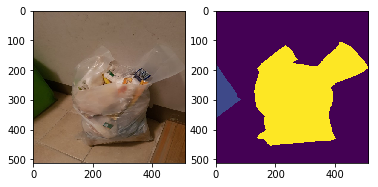

In [104]:
test_image = train_dataset[0][0].permute(1, 2, 0).numpy()
test_mask = train_dataset[0][1].numpy()

print(f"image shape : {test_image.shape}")
print(f"mask shape : {test_mask.shape}")

plt.subplot("121")
plt.imshow(test_image)
plt.subplot("122")
plt.imshow(test_mask)
plt.show()

transformed image shape : (256, 256, 3)
transformed mask shape : (256, 256)


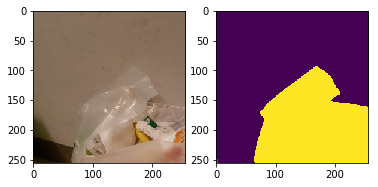

In [105]:
transformed = transform(image=test_image, mask=test_mask)
transformed_image = transformed["image"]
transformed_mask = transformed["mask"]

print(f"transformed image shape : {transformed_image.shape}")
print(f"transformed mask shape : {transformed_mask.shape}")

plt.subplot("121")
plt.imshow(transformed_image)
plt.subplot("122")
plt.imshow(transformed_mask)
plt.show()